## XGBoost & Bayesian optimization
This notebook shows the resolution of the Titanic's problem with a XGBoost, optimised using Bayesian optimisation.We will also look at the different steps in data analysis.

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style

### Data recovery

In [2]:
df_train=pd.read_csv("./kaggle/input/titanic/train.csv")
df_test=pd.read_csv("./kaggle/input/titanic/test.csv")

### Data analysis


In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
df_test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [5]:
df_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [6]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
total = df_train.isnull().sum()
percent = round(df_train.isnull().sum()/df_train.isnull().count()*100)
missing_data = pd.concat([total, percent], axis=1, keys=['Missing data', 'percent of missing data'])
missing_data

,Missing data,percent of missing data
PassengerId,0,0.0
Survived,0,0.0
Pclass,0,0.0
Name,0,0.0
Sex,0,0.0
Age,177,20.0
SibSp,0,0.0
Parch,0,0.0
Ticket,0,0.0
Fare,0,0.0


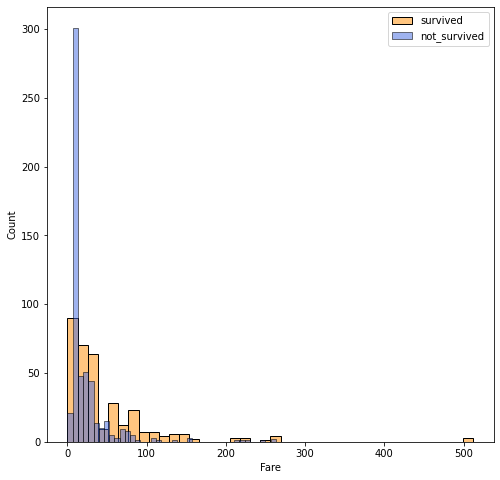

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(8, 8))
ax = sns.histplot(df_train[df_train['Survived']==1].Fare.dropna(), bins=40, label = 'survived', kde =False, color = 'darkorange', alpha=0.5)
ax = sns.histplot(df_train[df_train['Survived']==0].Fare.dropna(), bins=40, label = 'not_survived', kde =False, color = 'royalblue', alpha=0.5)
ax.legend()

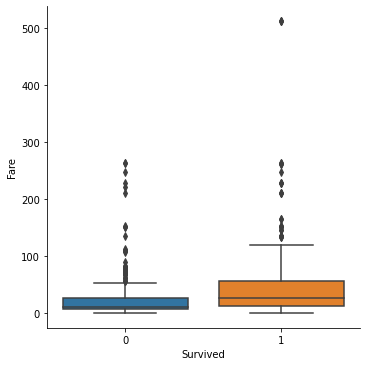

In [9]:
sns.catplot(x='Survived', y='Fare', kind="box", data=df_train)

Text(0.5, 1.0, 'Age distribution')

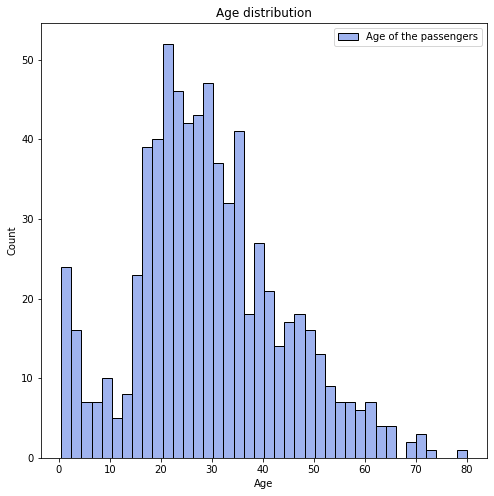

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(8, 8))
ax = sns.histplot(df_train.Age.dropna(),bins=40, label = 'Age of the passengers', kde =False, color = 'royalblue', alpha=0.5)
ax.legend()
ax.set_title('Age distribution')

In [11]:
male = df_train[df_train['Sex']=='male']
female = df_train[df_train['Sex']=='female']

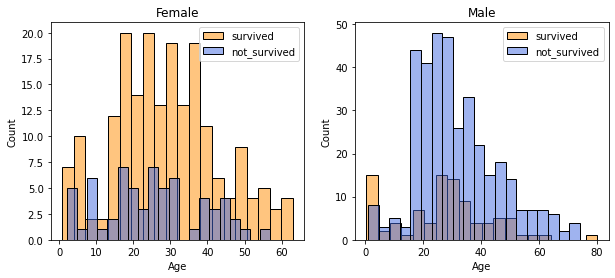

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10, 4))
ax = sns.histplot(female[female['Survived']==1].Age.dropna(), bins=20, label = 'survived', ax = axes[0], kde =False, color = 'darkorange', alpha=0.5)
ax = sns.histplot(female[female['Survived']==0].Age.dropna(), bins=20, label = 'not_survived', ax = axes[0], kde =False, color = 'royalblue', alpha=0.5)
ax.legend()
ax.set_title('Female')
ax = sns.histplot(male[male['Survived']==1].Age.dropna(), bins=20, label = 'survived', ax = axes[1], kde = False, color = 'darkorange', alpha=0.5)
ax = sns.histplot(male[male['Survived']==0].Age.dropna(), bins=20, label = 'not_survived', ax = axes[1], kde = False, color = 'royalblue', alpha=0.5)
ax.legend()
_ = ax.set_title('Male')

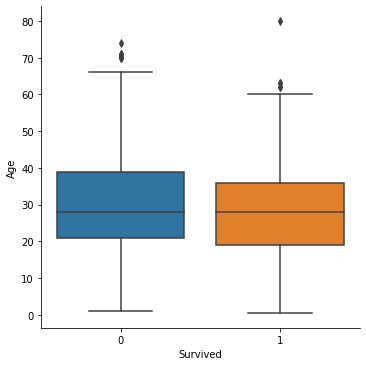

In [13]:
sns.catplot(x='Survived', y='Age', kind="box", data=df_train)

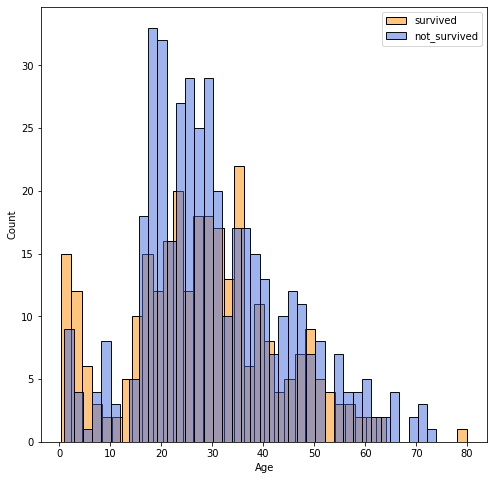

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(8, 8))
ax = sns.histplot(df_train[df_train['Survived']==1].Age.dropna(), bins=40, label = 'survived', kde =False, color = 'darkorange', alpha=0.5)
ax = sns.histplot(df_train[df_train['Survived']==0].Age.dropna(), bins=40, label = 'not_survived', kde =False, color = 'royalblue', alpha=0.5)
ax.legend()

In [15]:
df_train['tmp_age'] = pd.qcut(df_train['Age'], 6)
age_slice=df_train[['tmp_age', 'Survived']].groupby(['tmp_age'], as_index=False).mean()

Text(0.5, 1.0, 'Chance to survive in function of the Pclass')

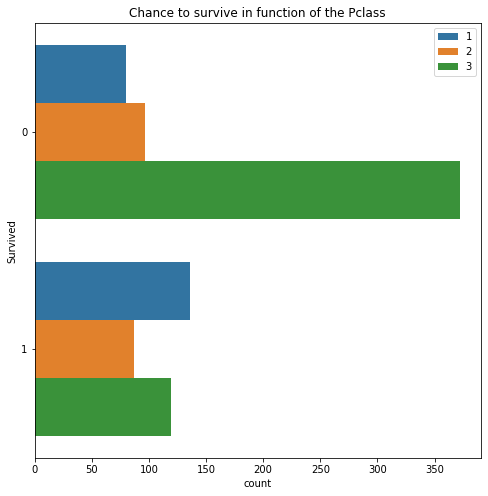

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(8, 8))
ax = sns.countplot(y='Survived', hue='Pclass', data=df_train)
ax.legend()
ax.set_title('Chance to survive in function of the Pclass')

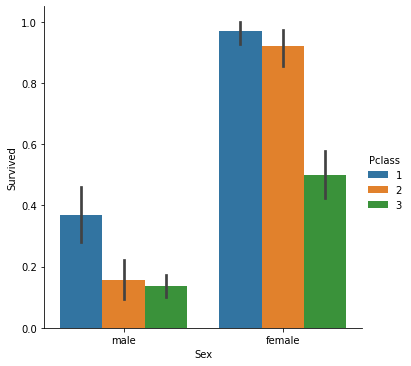

In [17]:
sns.catplot(x="Sex", y="Survived", hue="Pclass", kind="bar", data=df_train)

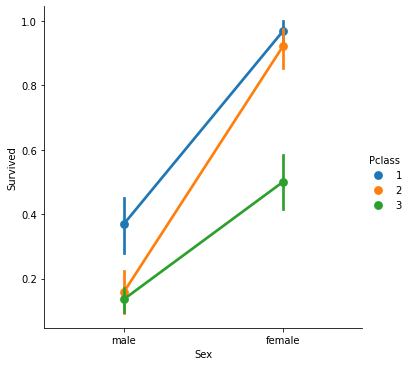

In [18]:
sns.catplot(x="Sex", y="Survived", hue="Pclass", kind="point", data=df_train)

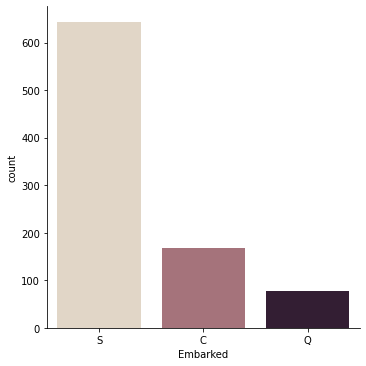

In [19]:
sns.catplot(x="Embarked", kind="count", palette="ch:.25", data=df_train)

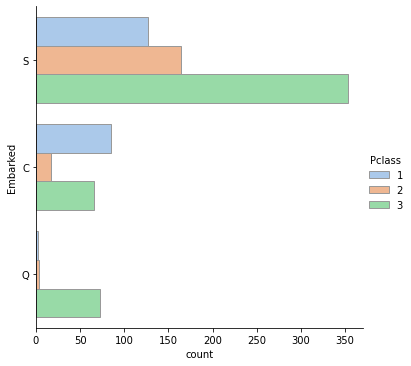

In [20]:
sns.catplot(y="Embarked", hue="Pclass", kind="count",
           palette="pastel", edgecolor=".6",
            data=df_train)

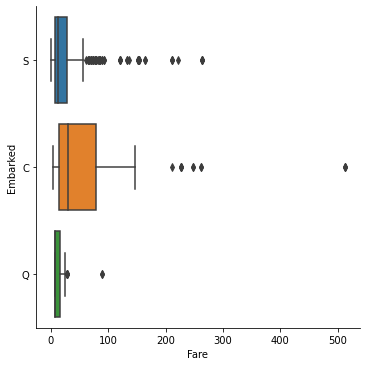

In [21]:
sns.catplot(x="Fare", y="Embarked", kind="box", data=df_train)

<AxesSubplot:xlabel='SibSp', ylabel='count'>

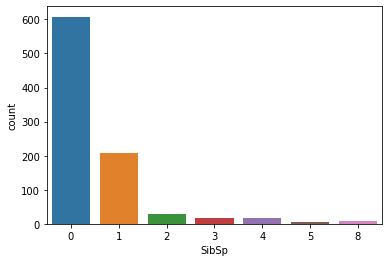

In [22]:
sns.countplot(x='SibSp',data=df_train)

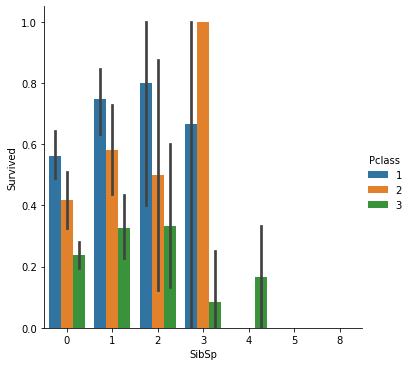

In [23]:
sns.catplot(x="SibSp", y="Survived", hue="Pclass", kind="bar", data=df_train)

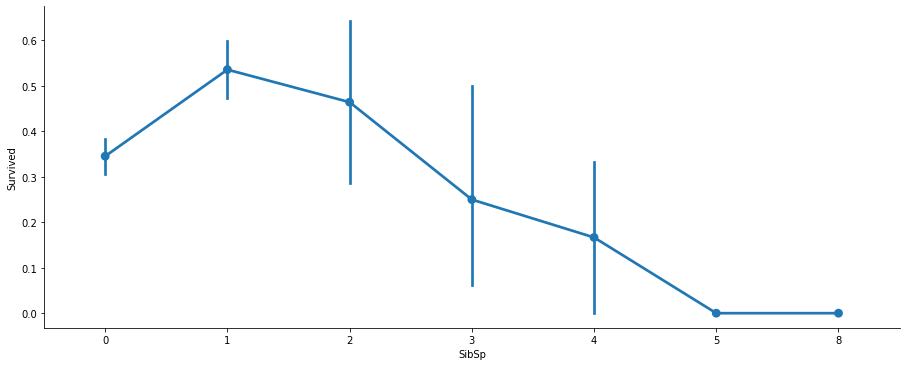

In [24]:
sns.catplot(x='SibSp',y='Survived', kind='point', data=df_train, aspect = 2.5)

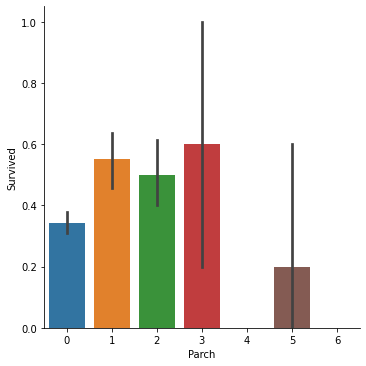

In [25]:
sns.catplot(x="Parch", y="Survived" , kind="bar", data=df_train)

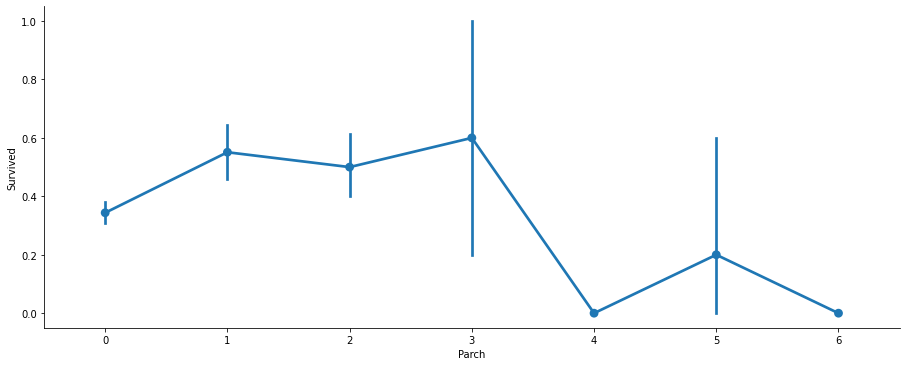

In [26]:
sns.catplot(x='Parch',y='Survived', kind='point',data=df_train, aspect = 2.5)

Data preprocessing
First of all we gone extract the information contain in the variable cabin. The varaible cabin is composed of the deck and the number of the cabin. So we will replace the column Cabin by a column Deck.

In [27]:
df_test[['Fare', 'Pclass']].groupby(['Pclass']).mean()

,Fare
Pclass,
1,94.280297
2,22.202104
3,12.459678


In [28]:
df_test[['Fare', 'Sex']].groupby(['Sex']).mean()

,Fare
Sex,
female,49.747699
male,27.527877


In [29]:
mean_pclass_1=df_test[df_test["Pclass"]==1]["Fare"].mean()
mean_pclass_2=df_test[df_test["Pclass"]==2]["Fare"].mean()
mean_pclass_3=df_test[df_test["Pclass"]==3]["Fare"].mean()

In [30]:
df_test[df_test["Pclass"]==1]=df_test[df_test["Pclass"]==1].fillna({'Fare':mean_pclass_1})
df_test[df_test["Pclass"]==2]=df_test[df_test["Pclass"]==2].fillna({'Fare':mean_pclass_2})
df_test[df_test["Pclass"]==3]=df_test[df_test["Pclass"]==3].fillna({'Fare':mean_pclass_3})

In [31]:
mean_male=(df_train[df_train["Sex"]=="male"]["Age"].mean()+df_test[df_test["Sex"]=="male"]["Age"].mean())/2
mean_female=(df_train[df_train["Sex"]=="female"]["Age"].mean()+df_test[df_test["Sex"]=="female"]["Age"].mean())/2

In [32]:
df_train.loc[df_train["Sex"]=="male","Age"]=df_train.loc[df_train["Sex"]=="male","Age"].fillna(mean_male)
df_train.loc[df_train["Sex"]=="female","Age"]=df_train.loc[df_train["Sex"]=="female","Age"].fillna(mean_female)
df_test.loc[df_test["Sex"]=="male","Age"]=df_test.loc[df_test["Sex"]=="male","Age"].fillna(mean_male)
df_test.loc[df_test["Sex"]=="female","Age"]=df_test.loc[df_test["Sex"]=="female","Age"].fillna(mean_female)

In [33]:
def bins_columns(train, test, bins_list,labels_list, column ):
    """ 
    Segment the values of the two lists, training and test, into intervals. Change the continuous 
    variables to a categorical variables.
    ------
    train : (PandasDataFrame) Dataframe passed in parameters who represent the train set 

    test : (PandasDataFrame Dataframe passed in parameters who represent the test set
    
    bins_list: (List) List of the differents interval used to pass the continuous variables into categorical
    
    labels_list: (List) Name of the categories created thanks to the bins list
    
    column: the name of the column who has to be modified

    Returns
    -------     
    data_train_modif: the train Dataframe with the column modified into categorical variables
    data_test_modif: the test Dataframe with the column modified into categorical variables
    """
    data=[train.copy(),test.copy()]
    for dataset in data:
        if dataset[column].dtypes.name!='category':
            dataset[column]=pd.cut(x=dataset[column], bins=bins_list, labels=labels_list)
            dataset[column]=dataset[column].astype('category')
    dic_cat=dict(enumerate(data[0][column].cat.categories ))
    dic_cat={v: k for k, v in dic_cat.items()}
    for i in range(len(data)):
        data[i]=data[i].replace({column: dic_cat})
    data_train_modif = data[0]
    data_test_modif = data[1]
    return data_train_modif, data_test_modif

In [34]:
df_train[["Age", "Survived"]].groupby(['Age'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Age,Survived
0,0.42,1.0
9,5.00,1.0
81,63.00,1.0
70,53.00,1.0
1,0.67,1.0
...,...,...
30,23.50,0.0
14,10.00,0.0
37,28.50,0.0
63,46.00,0.0


In [35]:
df_train['tmp_age'] = pd.qcut(df_train['Age'], 5)
age_slice=df_train[['tmp_age', 'Survived']].groupby(['tmp_age'], as_index=False).mean()

In [36]:
bins_list=[0,20,28,31,38,80]
labels_list=['0-20', '20-28', '28-31', '31-38','38-80']
df_train, df_test=bins_columns(df_train, df_test, bins_list,labels_list, "Age")

In [37]:
df_train['tmp_Fare'] = pd.qcut(df_train['Fare'], 5)
fare_slice=df_train[['tmp_Fare', 'Survived']].groupby(['tmp_Fare'], as_index=False).mean()

In [38]:
fare_slice

,tmp_Fare,Survived
0,"(-0.001, 7.854]",0.217877
1,"(7.854, 10.5]",0.201087
2,"(10.5, 21.679]",0.424419
3,"(21.679, 39.688]",0.444444
4,"(39.688, 512.329]",0.642045


In [39]:
bins_list=[-1,7.85,10.5,21.67,39.68,513]
labels_list=['0-7.85', '7.85-10.5', '10.5-21.67', '21.67-39.68', '39.68-513']
df_train, df_test=bins_columns(df_train, df_test, bins_list,labels_list, "Fare")

In [40]:
combine=[df_train,df_test]

In [41]:
for dataFrame in combine:
    dataFrame['Title'] = dataFrame.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(df_train['Title'], df_train['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [42]:
for dataFrame in combine:
    dataFrame['Title'] = dataFrame['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Other')

    dataFrame['Title'] = dataFrame['Title'].replace('Mlle', 'Miss')
    dataFrame['Title'] = dataFrame['Title'].replace('Ms', 'Miss')
    dataFrame['Title'] = dataFrame['Title'].replace('Mme', 'Mrs')
    
df_train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Other,0.347826


In [43]:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Other": 5}
for dataFrame in combine:
    dataFrame['Title'] = dataFrame['Title'].map(title_mapping)
    dataFrame['Title'] = dataFrame['Title'].fillna(0)

df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,tmp_age,tmp_Fare,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,1,1,0,A/5 21171,0,NaN,S,"(20.0, 28.0]","(-0.001, 7.854]",1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,3,1,0,PC 17599,4,C85,C,"(30.5, 38.0]","(39.688, 512.329]",3
2,3,1,3,"Heikkinen, Miss. Laina",female,1,0,0,STON/O2. 3101282,1,NaN,S,"(20.0, 28.0]","(7.854, 10.5]",2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,3,1,0,113803,4,C123,S,"(30.5, 38.0]","(39.688, 512.329]",3
4,5,0,3,"Allen, Mr. William Henry",male,3,0,0,373450,1,NaN,S,"(30.5, 38.0]","(7.854, 10.5]",1


In [44]:
df_train=df_train.dropna(subset=['Embarked'])
df_test=df_test.dropna(subset=['Embarked'])

In [45]:
dic_cat_sex={'male':0,'female':1}
df_train=df_train.replace({"Sex": dic_cat_sex })
df_test=df_test.replace({"Sex": dic_cat_sex })

In [46]:
df_train.Embarked=df_train.Embarked.astype('category')
dic_cat_embarked=dict(enumerate(df_train.Embarked.cat.categories ))
dic_cat_embarked = {v: k for k, v in dic_cat_embarked.items()}
df_train=df_train.replace({"Embarked": dic_cat_embarked })
df_test=df_test.replace({"Embarked": dic_cat_embarked })

In [47]:
df_train.Cabin=df_train.Cabin.fillna("Unknown")
df_test.Cabin=df_test.Cabin.fillna("Unknown")

In [48]:
df_train.Cabin=df_train.Cabin.apply(lambda x: str(x)[0] )
df_test.Cabin=df_test.Cabin.apply(lambda x: str(x)[0] )
df_train.Cabin=df_train.Cabin.astype('category')
dic_cat_cabine=dict(enumerate(df_train.Cabin.cat.categories ))
dic_cat_cabine = {v: k for k, v in dic_cat_cabine.items()}
df_train=df_train.replace({"Cabin": dic_cat_cabine })
df_test=df_test.replace({"Cabin": dic_cat_cabine })

In [49]:
df_train=df_train.rename(columns={'Cabin': 'Deck'})
df_test=df_test.rename(columns={'Cabin': 'Deck'})

In [50]:
df_test.isnull().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Deck           0
Embarked       0
Title          0
dtype: int64

In [51]:
df_train.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Deck           0
Embarked       0
tmp_age        0
tmp_Fare       0
Title          0
dtype: int64

In [52]:
df_train=df_train.drop(labels = ["PassengerId","Name","Ticket","tmp_Fare","tmp_age"], axis=1)
df_test_passengerID=df_test.PassengerId
df_test=df_test.drop(labels = ["PassengerId","Name","Ticket"], axis=1)

In [53]:
pd.get_dummies(df_train["Pclass"])

,1,2,3
0,0,0,1
1,1,0,0
2,0,0,1
3,1,0,0
4,0,0,1
...,...,...,...
886,0,1,0
887,1,0,0
888,0,0,1
889,1,0,0


In [54]:
X=df_train.loc[:, df_train.columns != 'Survived']
y=df_train.Survived

XGBoost

In [55]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, roc_curve, accuracy_score as acc
from sklearn import metrics
import itertools
from sklearn.model_selection import StratifiedKFold
import xgboost
from xgboost import XGBClassifier
import operator

In [56]:
#separating the our dataset in train, test and validation set
X_train, X_val, y_train, y_val  = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test    = train_test_split(X_val, y_val, test_size=0.5, random_state=42, stratify=y_val)

In [57]:
# Convert our data into XGBoost format
X_train_xgb = xgboost.DMatrix(X_train, label=y_train)
X_val_xgb = xgboost.DMatrix(X_val, label=y_val)
X_test_xgb = xgboost.DMatrix(X_test, label=y_test)

In [58]:

# Parameter of XGBoost model
xgb_params = {
    'objective': 'binary:logistic',
    'learning_rate': 0.03,
    'max_depth': 8,
    'min_child_weight': 1,
    'eval_metric':'auc',
    'nthread': -1
}

#watchlist is a list of xgb.DMatrix, each of them is tagged with name
watchlist = [ (X_train_xgb,'train'), (X_val_xgb,'validation')]

In [59]:
#train the XGBoost
model = xgboost.train(xgb_params, X_train_xgb , 2500, evals=watchlist, early_stopping_rounds=1000, verbose_eval =10)

#predict the value on the test set 
y_test_xgb  = model.predict(X_test_xgb)


[0]	train-auc:0.90276	validation-auc:0.83477
[10]	train-auc:0.90938	validation-auc:0.83907
[20]	train-auc:0.91368	validation-auc:0.83991
[30]	train-auc:0.92419	validation-auc:0.82293
[40]	train-auc:0.92696	validation-auc:0.82018
[50]	train-auc:0.93111	validation-auc:0.79232
[60]	train-auc:0.93329	validation-auc:0.79185
[70]	train-auc:0.93443	validation-auc:0.79161
[80]	train-auc:0.93758	validation-auc:0.78910
[90]	train-auc:0.93911	validation-auc:0.78874
[100]	train-auc:0.94015	validation-auc:0.79304
[110]	train-auc:0.94089	validation-auc:0.79412
[120]	train-auc:0.94461	validation-auc:0.79340
[130]	train-auc:0.94780	validation-auc:0.79448
[140]	train-auc:0.95032	validation-auc:0.79256
[150]	train-auc:0.95208	validation-auc:0.79053
[160]	train-auc:0.95381	validation-auc:0.78431
[170]	train-auc:0.95524	validation-auc:0.78097
[180]	train-auc:0.95649	validation-auc:0.78168
[190]	train-auc:0.95739	validation-auc:0.77953
[200]	train-auc:0.95804	validation-auc:0.77905
[210]	train-auc:0.95855	

Text(0.5, 0, 'importance relative')

<Figure size 432x288 with 0 Axes>

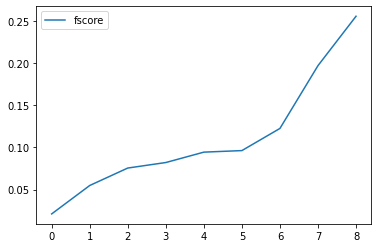

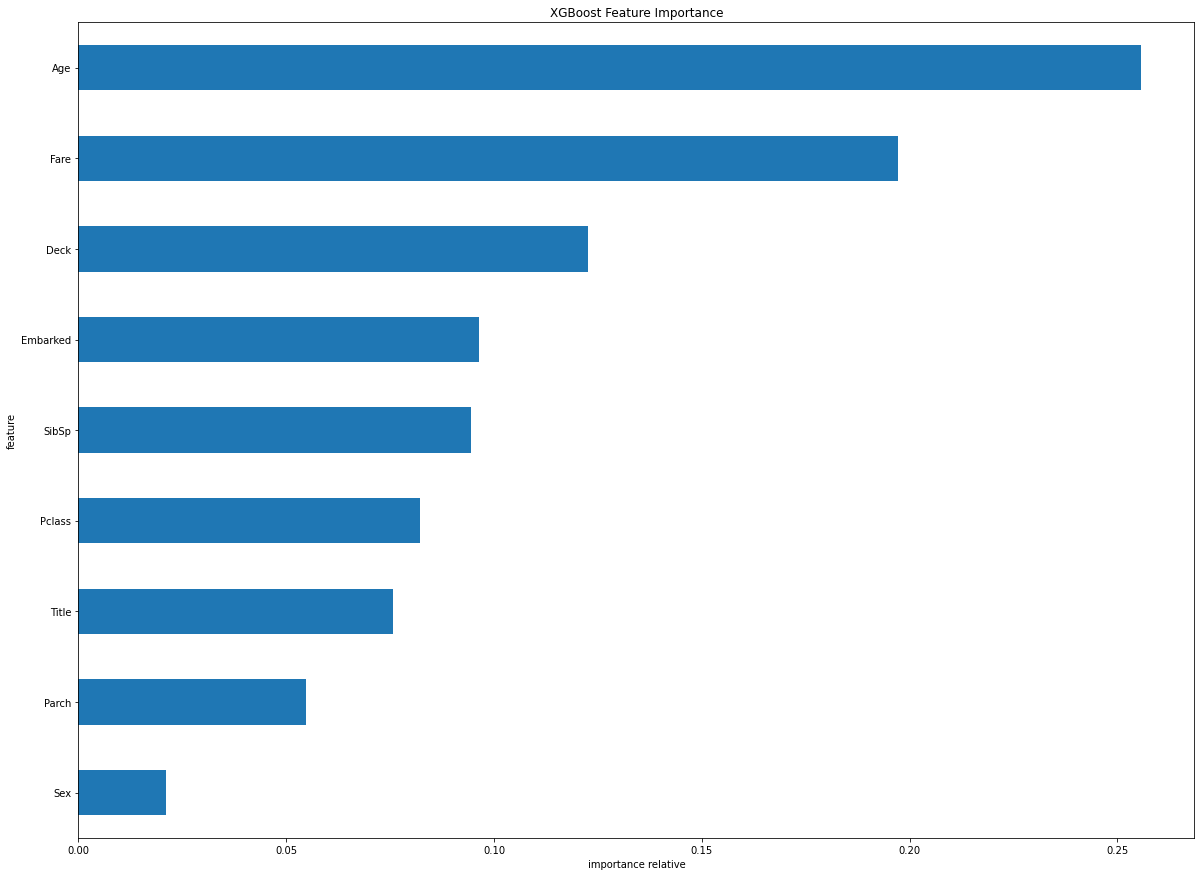

In [60]:
# importance of the variables according to the XGBoost after training
importance = model.get_fscore()
importance = sorted(importance.items(), key=operator.itemgetter(1))

df_fscore = pd.DataFrame(importance, columns=['feature', 'fscore'])
df_fscore ['fscore'] = df_fscore['fscore'] / df_fscore['fscore'].sum()

plt.figure()
df_fscore .iloc[-20:].plot()
df_fscore .iloc[-20:].plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(20, 15))
plt.title('XGBoost Feature Importance')
plt.xlabel('importance relative')

In [61]:
df_fscore.sort_values('fscore', ascending=False)

,feature,fscore
8,Age,0.255783
7,Fare,0.197149
6,Deck,0.122610
5,Embarked,0.096305
4,SibSp,0.094458
3,Pclass,0.082129
2,Title,0.075582
1,Parch,0.054859
0,Sex,0.021124


In [62]:
def roc_curve_and_confusion_matrix(y_true_label, y_pred, algo_name_condition):
    """ 
    Calculate the threshold and the classification report (recall, F1 score, precision) and display the ROC 
    curve and the confusion matrix. 
    ------
    y_true_label : (List) The true label of the predicted variable 

    y_pred : (List) Prédiction generated by the algorithm
    
    title: (String) Name of the algorithm and the condition in which it was execute 

    Returns
    -------     
    threshold: Represent the best cutoff finds in the list of thresholds generated by the function roc_curve
    
    classif_report: text report showing the main classification metrics, precision, recall, f1-score
    """
    fpr, tpr, threshold = metrics.roc_curve(y_true_label, y_pred)
    roc_auc = metrics.auc(fpr, tpr)

    fig, ax = plt.subplots(1, 2, figsize=(10, 5)) 
    ax[0].set_title("Receiver Operating Characteristic "+algo_name_condition)
    ax[0].plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc, antialiased=True)
    ax[0].plot([0, 1], [0, 1],'r--')
    ax[0].axis(xmin=0,xmax=1, ymin=0,ymax=1)
    ax[0].legend(loc = 'lower right', prop={'size': 14})
    ax[0].set_ylabel('True Positive Rate')
    ax[0].set_xlabel('False Positive Rate')
    
    
    
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.loc[(roc.tf).abs().argsort()[:1]]
    threshold=list(roc_t['threshold'])
    
    
    y_pred_thresh = np.where(y_pred >= threshold, 1, 0).astype(int)
    conf_matrix = confusion_matrix(y_true_label, y_pred_thresh)
    labels=['survived','has not survived']
    
    img =ax[1].imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)

    ax[1].set_title("Confusion matrix "+algo_name_condition)
    fig.colorbar(img)
    tick_marks = np.arange(len(labels))
    ax[1].set_xticks(tick_marks)
    ax[1].set_xticklabels( labels, rotation=45, size=15)
    ax[1].set_yticks(tick_marks)
    ax[1].set_yticklabels( labels, size=15)

    thresh = conf_matrix.max() / 2.
    for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
        ax[1].text(j, i, conf_matrix[i, j],
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

    fig.tight_layout()
    ax[1].set_ylabel('True label')
    ax[1].set_xlabel('Predicted label')
    
    plt.show
    classif_report=classification_report(y_true_label, y_pred_thresh)
    return threshold, classif_report

              precision    recall  f1-score   support

           0       0.85      0.77      0.81        83
           1       0.68      0.78      0.73        51

    accuracy                           0.78       134
   macro avg       0.77      0.78      0.77       134
weighted avg       0.79      0.78      0.78       134



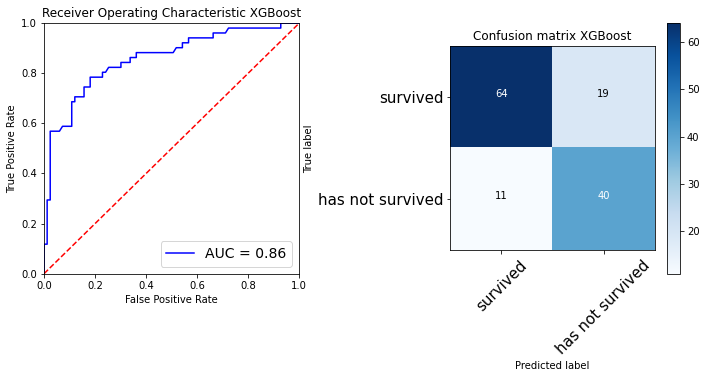

In [63]:
_, classif_report=roc_curve_and_confusion_matrix(y_test, y_test_xgb, "XGBoost")
print(classif_report)

Precision means the percentage of your results which are relevant.
Precision is the number of correctly identified members of a class divided by all the times the model predicted that class. In our case we have a precision of 67% to predict the class: "has not survived",40/59.

On the other hand, recall refers to the percentage of total relevant results correctly classified by your algorithm.
Recall is the number of members of a class that the classifier identified correctly divided by the total number of members in that class. The recall tells us that when we predict: "has not survived",78% of the passengers did not survive.

The F1 score is used to determine how good an algorithm is at identifying members of a class, or whether it is biased and identifies everyone as a member of a large class.


### Coss Validation
Our XGBoost seems to perform well on the test set. But we can't guarantee that this model will perform on new data. Indeed, we used only a part of the data set to train, and only a part to test. The estimation could be biased.

Cross-validation allows us to estimate the reliability of a model based on a sampling technique using the entire dataset.

In [64]:
# Number of fold
kfold = 5
skf = StratifiedKFold(n_splits=kfold)

xgb_params = {
    'objective': 'binary:logistic', # classification problem
    'learning_rate': 0.03,
    'max_depth': 8,
    'min_child_weight': 1,
    'eval_metric':'auc', # Using the metrics AUC to compute the performance of the model 
    'nthread': -1
}


X_cross = np.array(X_train)
y_cross = np.array(y_train)
test = np.array(X_test)
id_test = X_test.index.values

register_data = pd.DataFrame()
register_data['id'] = id_test
register_data['target'] = np.zeros_like(id_test)

# Create the split for the Kfold
for i, (train_index, test_index) in enumerate(skf.split(X_cross, y_cross)):
    print('Fold '+str(i+1)+'/'+str(kfold))
    # Split the data
    X_train_cross_val, X_val_cross_val = X_cross[train_index], X_cross[test_index]
    y_train_cross_val, y_val_cross_val = y_cross[train_index], y_cross[test_index]
    
    
    X_cross_val_train_xgb = xgboost.DMatrix(X_train_cross_val, y_train_cross_val)
    X_cross_val_valid_xgb = xgboost.DMatrix(X_val_cross_val, y_val_cross_val)
    X_test_xgb = xgboost.DMatrix(X_test.values)
    watchlist = [(X_cross_val_train_xgb, 'train'), (X_cross_val_valid_xgb, 'valid')]

    # Train the model. In max 2500 rounds
    # early_stopping_rounds: it works by monitoring the performance of the model that is being trained
        # on a separate test dataset and stopping the training procedure once the performance on the test dataset 
        # has not improved after a fixed number of training iterations.
    mdl = xgboost.train(xgb_params, X_cross_val_train_xgb , 2500, evals=watchlist, early_stopping_rounds=60, verbose_eval =10)
    # Predict on our test data
    p_test = mdl.predict(X_test_xgb)
    register_data['target'] += p_test/kfold
    
fpr, tpr, threshold = metrics.roc_curve(y_test, register_data.target)
roc_auc = metrics.auc(fpr, tpr)
before_opti = roc_auc
print('AUC on cross-validation :',roc_auc)

Fold 1/5
[0]	train-auc:0.89755	valid-auc:0.91044
[10]	train-auc:0.90342	valid-auc:0.91410
[20]	train-auc:0.90538	valid-auc:0.91477
[30]	train-auc:0.91612	valid-auc:0.90490
[40]	train-auc:0.92006	valid-auc:0.91342
[50]	train-auc:0.92779	valid-auc:0.90787
[60]	train-auc:0.92992	valid-auc:0.90517
[70]	train-auc:0.93305	valid-auc:0.90138
[75]	train-auc:0.93392	valid-auc:0.89773
Fold 2/5
[0]	train-auc:0.89603	valid-auc:0.89218
[10]	train-auc:0.90587	valid-auc:0.88447
[20]	train-auc:0.90771	valid-auc:0.88582
[30]	train-auc:0.91375	valid-auc:0.88650
[40]	train-auc:0.92649	valid-auc:0.88650
[50]	train-auc:0.93400	valid-auc:0.88988
[60]	train-auc:0.93772	valid-auc:0.88636
Fold 3/5
[0]	train-auc:0.90213	valid-auc:0.89500
[10]	train-auc:0.90262	valid-auc:0.91241
[20]	train-auc:0.91267	valid-auc:0.90591
[30]	train-auc:0.91696	valid-auc:0.90260
[40]	train-auc:0.91952	valid-auc:0.90260
[50]	train-auc:0.92641	valid-auc:0.89887
[60]	train-auc:0.93097	valid-auc:0.90356
[70]	train-auc:0.93358	valid-auc:

              precision    recall  f1-score   support

           0       0.89      0.82      0.86        83
           1       0.74      0.84      0.79        51

    accuracy                           0.83       134
   macro avg       0.82      0.83      0.82       134
weighted avg       0.84      0.83      0.83       134



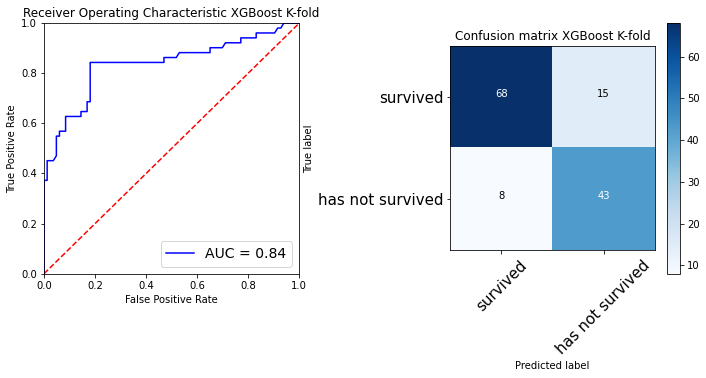

In [65]:
_, classif_report=roc_curve_and_confusion_matrix(y_test, np.array(register_data.target), "XGBoost K-fold")
print(classif_report)

### Bayesian Optimization

In [66]:
from bayes_opt import BayesianOptimization

def xgb_evaluate(n_estimators,learning_rate, max_depth, subsample, min_child_weight, gamma, colsample_bytree):    
    """ Compute the best parameters of XGboost
    Params
    ------
    learning_rate : Step size shrinkage used in update to prevents overfitting. 
    max_depth : Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit. 
    subsample: Subsample ratio of the training instances (prevent overfitting). Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees. 
    min_child_weight : Minimum sum of instance weight (hessian) needed in a child. 
    gamma : Minimum loss reduction required to make a further partition on a leaf node of the tree. 
    colsample_bytree : Subsample ratio of columns when constructing each tree.

    Returns
    -------     
    list type, with optimal cutoff value

    """
    params = {
        'num_parallel_tree':int(n_estimators),
        'eta': learning_rate,
        'max_depth': int(max_depth),
        'subsample': max(min(subsample, 1), 0),
        'objective': 'binary:logistic',
        'base_score': np.mean(y_train), # base prediction = mean(target)
        'eval_metric':'auc',
        'min_child_weight': int(min_child_weight),
        'gamma': max(gamma, 0),
        'colsample_bytree': colsample_bytree,
        'nthread': -1
    }
    

    X_cross = np.array(X_train)
    Y_cross = np.array(y_train)
    test = np.array(X_test)
    id_test = X_test.index.values

    register_data = pd.DataFrame()
    register_data['id'] = id_test
    register_data['target'] = np.zeros_like(id_test)

    for i, (train_index, test_index) in enumerate(skf.split(X_cross, y_cross)):
        
        X_train_cross_val, X_val_cross_val = X_cross[train_index], X_cross[test_index]
        y_train_cross_val, y_val_cross_val = y_cross[train_index], y_cross[test_index]


        X_cross_val_train_xgb = xgboost.DMatrix(X_train_cross_val, y_train_cross_val)
        X_cross_val_valid_xgb = xgboost.DMatrix(X_val_cross_val, y_val_cross_val)
        X_test_xgb = xgboost.DMatrix(X_test.values)
        watchlist = [(X_cross_val_train_xgb, 'train'), (X_cross_val_valid_xgb, 'valid')]
        
        mdl = xgboost.train(params, X_cross_val_train_xgb , 25000, evals=watchlist, early_stopping_rounds=50, verbose_eval = False)

        # Predict on our test data
        p_test = mdl.predict(X_test_xgb)
        register_data['target'] += p_test/kfold

    fpr, tpr, threshold = metrics.roc_curve(y_test, register_data.target)
    cv_result = metrics.auc(fpr, tpr)
    
    return cv_result


# Parameters for optimization
params = {
  'n_estimators': (10,100),
  'learning_rate':(0.01, 0.1),
  'min_child_weight':(1, 20),
  'gamma':(0, 5),
  'subsample':(0.8, 1),
  'colsample_bytree':(0.3, 0.8),
  'max_depth': (2, 10)
}

# create model BayesianOptimisation
xgb_bo = BayesianOptimization(xgb_evaluate,params)

# Compute optimals parameters
xgb_bo.maximize(init_points=20, n_iter=50)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        |  0.8488   |  0.5026   |  1.014    |  0.01334  |  5.283    |  2.47     |  41.16    |  0.8647   |
|  2        |  0.8287   |  0.5919   |  3.253    |  0.04362  |  2.231    |  13.14    |  96.12    |  0.8841   |
|  3        |  0.8488   |  0.6367   |  0.8781   |  0.0843   |  4.87     |  2.081    |  38.24    |  0.9703   |
|  4        |  0.822    |  0.4851   |  0.9166   |  0.0532   |  2.752    |  16.23    |  42.83    |  0.9041   |
|  5        |  0.8311   |  0.7429   |  0.08756  |  0.0116   |  6.545    |  5.516    |  54.19    |  0.8937   |
|  6        |  0.8218   |  0.7216   |  4.083    |  0.06441  |  8.742    |  12.76    |  73.75    |  0.9412   |
|  7        |  0.8353   |  0.6011   |  1.051    |  0.03014  |  8.558    |  5.656    |  69.7     |  0.9625   |
|  8      

|  45       |  0.8549   |  0.3      |  0.0      |  0.1      |  10.0     |  1.0      |  62.05    |  0.8      |
|  46       |  0.8668   |  0.8      |  0.0      |  0.1      |  10.0     |  1.0      |  57.47    |  0.8      |
|  47       |  0.841    |  0.3      |  4.033    |  0.1      |  10.0     |  1.0      |  54.96    |  0.8      |
|  48       |  0.8606   |  0.8      |  0.0      |  0.1      |  7.145    |  1.0      |  58.55    |  1.0      |
|  49       |  0.862    |  0.8      |  0.0      |  0.1      |  10.0     |  3.369    |  59.0     |  1.0      |
|  50       |  0.8053   |  0.8      |  0.0      |  0.01     |  2.0      |  20.0     |  85.6     |  1.0      |
|  51       |  0.8509   |  0.3      |  0.0      |  0.1      |  10.0     |  1.0      |  58.73    |  1.0      |
|  52       |  0.867    |  0.8      |  0.0      |  0.1      |  10.0     |  1.0      |  54.67    |  0.8      |
|  53       |  0.8429   |  0.8      |  0.0      |  0.1      |  8.148    |  4.96     |  62.64    |  0.8      |
|  54     

In [67]:
p = xgb_bo.max["params"]

In [68]:
# Best parameters
xgb_params = {
    'num_parallel_tree': int(p['n_estimators']),
    'eta': p['learning_rate'],
    'max_depth': int(p['max_depth']),
    'subsample': p['subsample'],
    'objective': 'binary:logistic',
    'base_score': np.mean(y_train),
    'eval_metric':'auc',
    'min_child_weight': int(p['min_child_weight']),
    'gamma': p['gamma'],
    'colsample_bytree': p['colsample_bytree']
}

In [69]:
X_cross = np.array(X_train)
y_cross = np.array(y_train)
test = np.array(X_test)
id_test = X_test.index.values

register_data = pd.DataFrame()
register_data['id'] = id_test
register_data['target'] = np.zeros_like(id_test)
best_ntree = 0

for i, (train_index, test_index) in enumerate(skf.split(X_cross, y_cross)): 
        print('Fold '+str(i+1)+'/'+str(kfold))
        X_train_cross_val, X_val_cross_val = X_cross[train_index], X_cross[test_index]
        y_train_cross_val, y_val_cross_val = y_cross[train_index], y_cross[test_index]


        X_cross_val_train_xgb = xgboost.DMatrix(X_train_cross_val, y_train_cross_val)
        X_cross_val_valid_xgb = xgboost.DMatrix(X_val_cross_val, y_val_cross_val)
        X_test_xgb = xgboost.DMatrix(X_test.values)
        watchlist = [(X_cross_val_train_xgb, 'train'), (X_cross_val_valid_xgb, 'valid')]

        mdl = xgboost.train(xgb_params, X_cross_val_train_xgb , 2500, evals=watchlist, early_stopping_rounds=60, verbose_eval = 50)
        best_ntree  += mdl.best_ntree_limit/kfold 


        # Predict on our test data
        p_test = mdl.predict(X_test_xgb)
        register_data['target'] += p_test/kfold
    
best_ntree = int(best_ntree)
fpr, tpr, threshold = metrics.roc_curve(y_test, register_data.target)
roc_auc = metrics.auc(fpr, tpr)
after_opti = roc_auc
print('AUC on cross-validation :',roc_auc)
print('Men best tree :', best_ntree)

Fold 1/5
[0]	train-auc:0.90576	valid-auc:0.89935
[50]	train-auc:0.95268	valid-auc:0.90030
[63]	train-auc:0.95813	valid-auc:0.90003
Fold 2/5
[0]	train-auc:0.91052	valid-auc:0.88163
[50]	train-auc:0.95237	valid-auc:0.89299
[100]	train-auc:0.96434	valid-auc:0.88352
[110]	train-auc:0.96568	valid-auc:0.88298
Fold 3/5
[0]	train-auc:0.90899	valid-auc:0.90495
[50]	train-auc:0.94703	valid-auc:0.91324
[99]	train-auc:0.96021	valid-auc:0.91075
Fold 4/5
[0]	train-auc:0.90640	valid-auc:0.87801
[50]	train-auc:0.95308	valid-auc:0.87400
[79]	train-auc:0.96167	valid-auc:0.86543
Fold 5/5
[0]	train-auc:0.92693	valid-auc:0.81072
[50]	train-auc:0.96495	valid-auc:0.79413
[61]	train-auc:0.96789	valid-auc:0.79002
AUC on cross-validation : 0.8667611622962439
Men best tree : 1285


In [70]:
change =(after_opti*100 / before_opti) - 100
print("Improvement through optimization : {}%".format(change))

Improvement through optimization : 3.5709244883557005%


              precision    recall  f1-score   support

           0       0.87      0.80      0.83        83
           1       0.71      0.80      0.75        51

    accuracy                           0.80       134
   macro avg       0.79      0.80      0.79       134
weighted avg       0.81      0.80      0.80       134



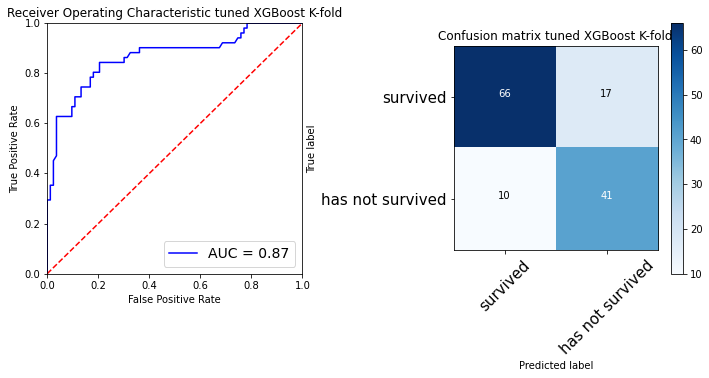

In [71]:
threshold,classif_report=roc_curve_and_confusion_matrix(y_test, np.array(register_data.target), "tuned XGBoost K-fold")
print(classif_report)

In [72]:
X_train_xgb = xgboost.DMatrix(X, y)

In [73]:
clf = xgboost.train(xgb_params, X_train_xgb , best_ntree, verbose_eval = 10)

In [74]:
X_test_xgb = xgboost.DMatrix(df_test)

In [75]:
result = clf.predict(X_test_xgb)

In [76]:
result_tresh=np.where(result >= threshold, 1, 0).astype(int)

In [77]:
df_test_passengerID=pd.DataFrame(df_test_passengerID)

In [78]:
df_test_passengerID["Survived"] = result_tresh


In [79]:
df_result = df_test_passengerID[["PassengerId", "Survived"]]

df_result.to_csv('XGBoost_Bayesian_optimization.csv', index=False)